In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy import signal
from scipy.interpolate import CubicSpline
import mpl_axes_aligner 
import seaborn as sns
sns.set_theme(style="darkgrid")

%matplotlib widget

# data=pd.read_csv("not_moving_trot.csv")
# table=data[7500:]

#files are named gait-speed-period
data=pd.read_csv("trot-1-0.2.csv")
table=data
print(len(table.index))

holder=[]
for i in range(len(table.index)):
    holder.append(table.qd00[i]*table.t00[i])
table.insert(len(table.columns), "p00", holder, True)
holder=[]
for i in range(len(table.index)):
    holder.append(table.qd01[i]*table.t01[i])
table.insert(len(table.columns), "p01", holder, True)
holder=[]
for i in range(len(table.index)):
    holder.append(table.qd02[i]*table.t02[i])
table.insert(len(table.columns), "p02", holder, True)



20451


In [4]:
def calculate_areas(start,end):
    positive_area=[0.0,0.0,0.0]
    negative_area=[0.0,0.0,0.0]
    time=0.001
    columns=['p00','p01','p02']
    for jj in range(3):
        for i in range(end-start):
            first_area=0.0
            second_area=0.0
            # print(table.p01[i+start],"  ",table.p01[i+start+1])
            if(table.loc[i+start,columns[jj]]>=0.0 and table.loc[i+start+1,columns[jj]]>=0.0):
                positive_area[jj]+=(table.loc[i+start,columns[jj]]+table.loc[i+start+1,columns[jj]])*time/2
            elif(table.loc[i+start,columns[jj]]<0.0 and table.loc[i+start+1,columns[jj]]<0.0):
                negative_area[jj]+=(table.loc[i+start,columns[jj]]+table.loc[i+start+1,columns[jj]])*time/2
            else:
                intersect=table.loc[i+start,columns[jj]]/(table.loc[i+start,columns[jj]]-table.loc[i+start+1,columns[jj]])*time
                first_area=table.loc[i+start,columns[jj]]*intersect/2
                second_area=table.loc[i+start+1,columns[jj]]*(time-intersect)/2
                if(first_area >=0.0):
                    positive_area[jj]+=first_area
                    negative_area[jj]+=second_area
                else:
                    positive_area[jj]+=second_area
                    negative_area[jj]+=first_area
    return positive_area,negative_area

def analyze_areas(start,end):
    min_power=[0.0,0.0,0.0]
    max_power=[0.0,0.0,0.0]
    start_window=[0,0,0]
    end_window=[0,0,0]
    max_neg_energy=[99999.9,99999.0,99999.0]
    time=0.001
    columns=['p00','p01','p02']
    for jj in range(3):
        temp_holder=0
        tmp_start=0
        tmp_end=0;
        for i in range(end-start):
            first_area=0.0
            second_area=0.0
            # print(table.p01[i+start],"  ",table.p01[i+start+1])
            if(table.loc[i+start,columns[jj]]>=0.0 and table.loc[i+start+1,columns[jj]]>=0.0):
                if( max_neg_energy[jj] > temp_holder):
                    max_neg_energy[jj]=temp_holder
                    start_window[jj]=tmp_start
                    end_window[jj]=tmp_end
                temp_holder=0
                tmp_start=i+start
            elif(table.loc[i+start,columns[jj]]<0.0 and table.loc[i+start+1,columns[jj]]<0.0):
                temp_holder+=(table.loc[i+start,columns[jj]]+table.loc[i+start+1,columns[jj]])*time/2
                tmp_end=i+start+1
            else:
                intersect=table.loc[i+start,columns[jj]]/(table.loc[i+start,columns[jj]]-table.loc[i+start+1,columns[jj]])*time
                first_area=table.loc[i+start,columns[jj]]*intersect/2
                second_area=table.loc[i+start+1,columns[jj]]*(time-intersect)/2
                if(first_area >=0.0):
                    if( max_neg_energy[jj] > temp_holder):
                        max_neg_energy[jj]=temp_holder
                        start_window[jj]=tmp_start
                        end_window[jj]=tmp_end
                    temp_holder=0
                    tmp_start=i+start
                    temp_holder+=second_area
                    tmp_end=i+start+1
                else:
                    temp_holder+=first_area
                    tmp_end=i+start+1
                    if( max_neg_energy[jj] > temp_holder):
                        max_neg_energy[jj]=temp_holder
                        start_window[jj]=tmp_start
                        end_window[jj]=tmp_end
                    temp_holder=0
                    tmp_start=i+start
        if( max_neg_energy[jj] > temp_holder):
            max_neg_energy[jj]=temp_holder
            start_window[jj]=tmp_start
            end_window[jj]=tmp_end
    return max_neg_energy,start_window,end_window

def analyze_range(graph,height_threshold,dist_threshold,start=0,end=20000):
    peaks, _ = find_peaks(table[graph], height=height_threshold,distance=dist_threshold)
    filtered_data=peaks[(peaks >= start) & (peaks <= end)]
    # print(filtered_data)
    # print(len(filtered_data))
    
    max_neg_energy=[0.0,0.0,0.0]
    neg_energy=[0.0,0.0,0.0]
    pos_energy=[0.0,0.0,0.0]
    window=[0,0,0]
    for tmprng in range(len(filtered_data)-1):
        # print(tmprng)
        a,b=calculate_areas(filtered_data[tmprng],filtered_data[tmprng+1])
        c,d,e=analyze_areas(filtered_data[tmprng],filtered_data[tmprng+1])
        for ii in range(3):
            pos_energy[ii]+=a[ii]
            neg_energy[ii]+=b[ii]
            max_neg_energy[ii]+=c[ii]
            window[ii]+=(e[ii]-d[ii])
    # max_neg_energy/=len(filtered_data)
    # neg_energy/=len(filtered_data)
    # pos_energy/=len(filtered_data)
    for ii in range(3):
            pos_energy[ii]=pos_energy[ii]/(len(filtered_data)-1)
            neg_energy[ii]=neg_energy[ii]/(len(filtered_data)-1)
            max_neg_energy[ii]=max_neg_energy[ii]/(len(filtered_data)-1)
            window[ii]=window[ii]/(len(filtered_data)-1)
    print("pos_energy: "+str(pos_energy))
    print("neg_energy: "+str(neg_energy))
    print("max_neg_energy: "+str(max_neg_energy))
    print("window: "+str(window))
    a,b=calculate_areas(filtered_data[0],filtered_data[-1])
    c,d,e=analyze_areas(filtered_data[0],filtered_data[-1])
    f=[0,0,0]
    for ii in range(3):
        a[ii]=a[ii]/(len(filtered_data)-1)
        b[ii]=b[ii]/(len(filtered_data)-1)
        f[ii]=e[ii]-d[ii]
    print("pos_energy: "+str(a))
    print("neg_energy: "+str(b))
    print("max_neg_energy: "+str(c))
    print("avg window: "+str(f))
    
    plt.close()
    plt.figure(figsize=(20,10))
    ax = plt.gca()
    plt.plot(table[graph])
    plt.plot(filtered_data, table[graph][filtered_data], 'ro')  # 'ro' stands for red dots at peak locations
    plt.title('Data with Peaks Above Threshold')
    plt.show()

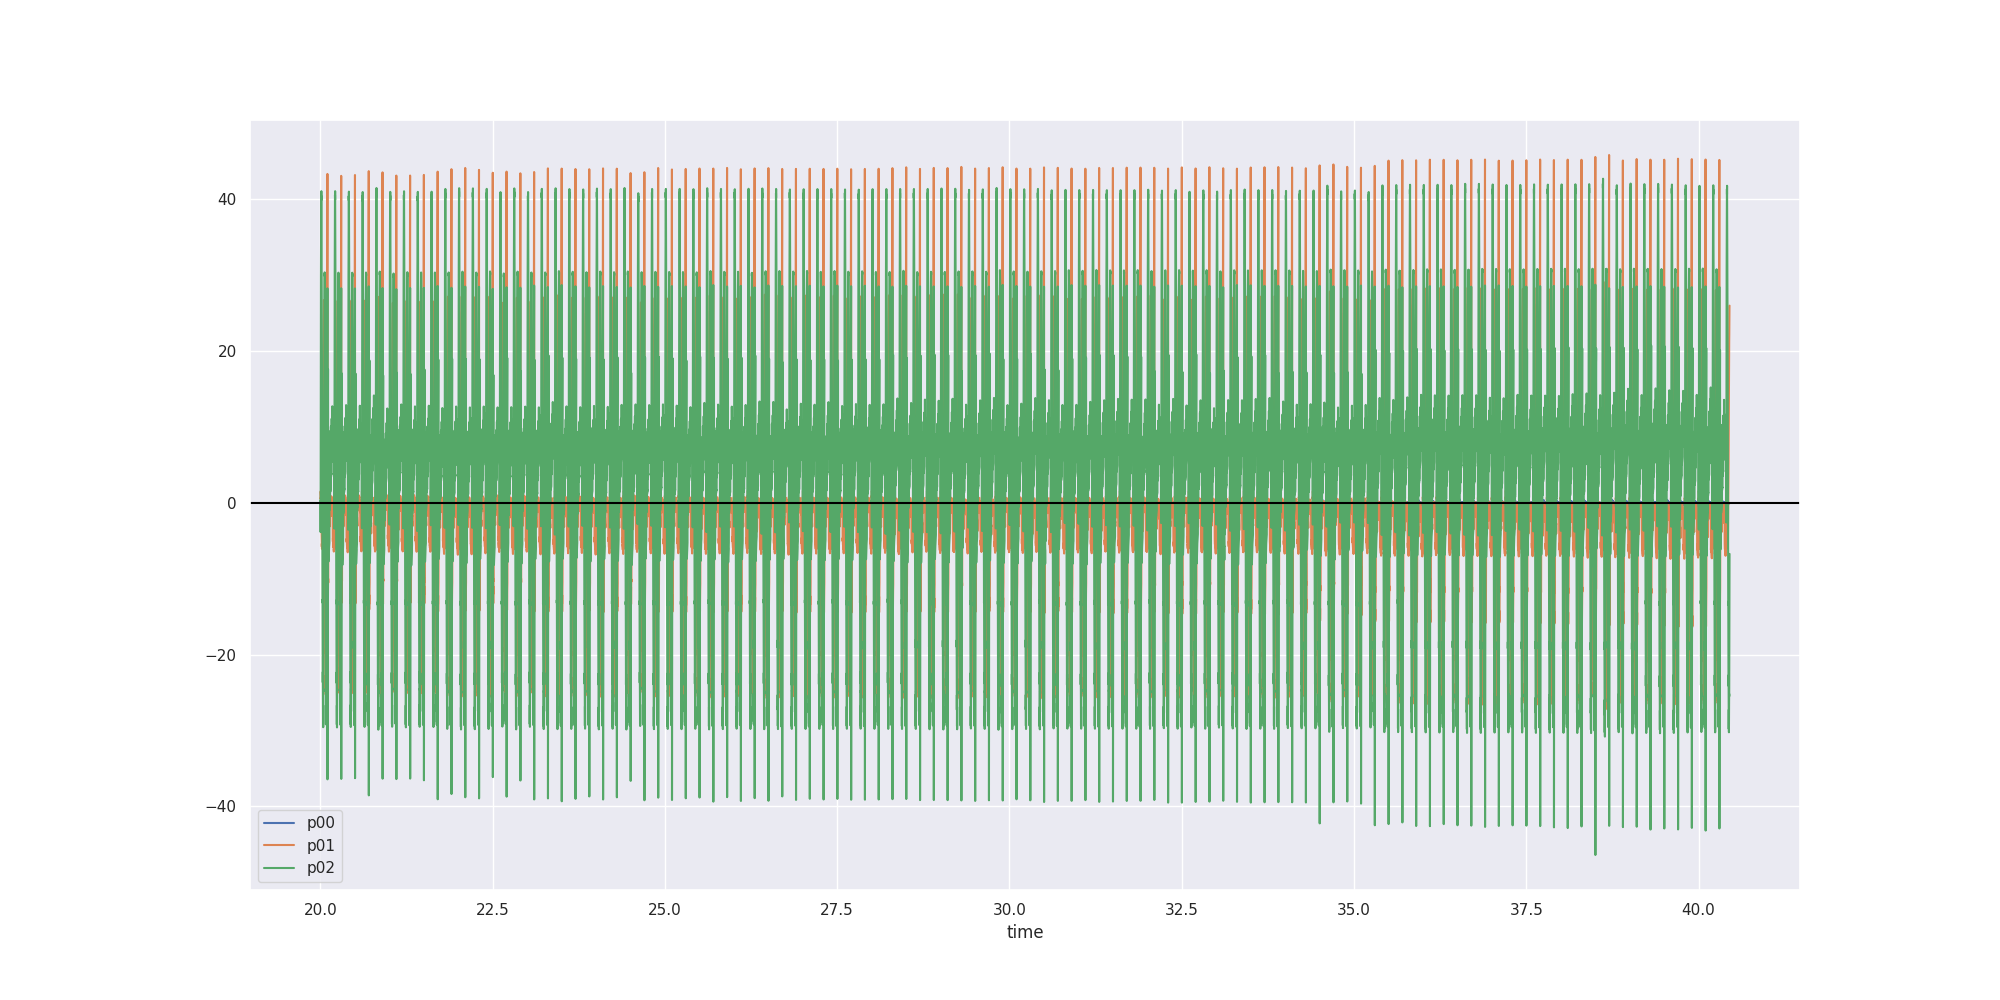

In [9]:
plt.close()
plt.figure(figsize=(20,10))
ax = plt.gca()

# table.plot( x = 'time' , y = 'q01', ax = ax )
table.plot( x = 'time' , y = 'p00', ax = ax )
table.plot( x = 'time' , y = 'p01', ax = ax )
table.plot( x = 'time' , y = 'p02', ax = ax )
# table.plot( x = 'time' , y = 'p02', ax = ax )
# table.plot( x = 'time' , y = 'qd00', ax = ax )
# table.plot( x = 'time' , y = 't00', ax = ax )
# table.plot( x = 'time' , y = 't01', ax = ax )

plt.axhline(y=0.0, color='black', linestyle='-')

plt.show()

pos_energy: [0.01083900211946881, 0.6631128771352598, 1.6768748890909633]
neg_energy: [-0.015803562476702615, -0.9964094073609906, -0.9537882591286629]
max_neg_energy: [-0.005963779725593288, -0.6006066282060404, -0.4410013071401191]
window: [20.575757575757574, 34.73737373737374, 24.07070707070707]
pos_energy: [0.010839002119468817, 0.6631128771352598, 1.6768748890909584]
neg_energy: [-0.015803562476702553, -0.9964094073609878, -0.9537882591286618]
max_neg_energy: [-0.008519637916510758, -0.6323384205389837, -0.45501217926536963]
avg window: [21, 34, 24]


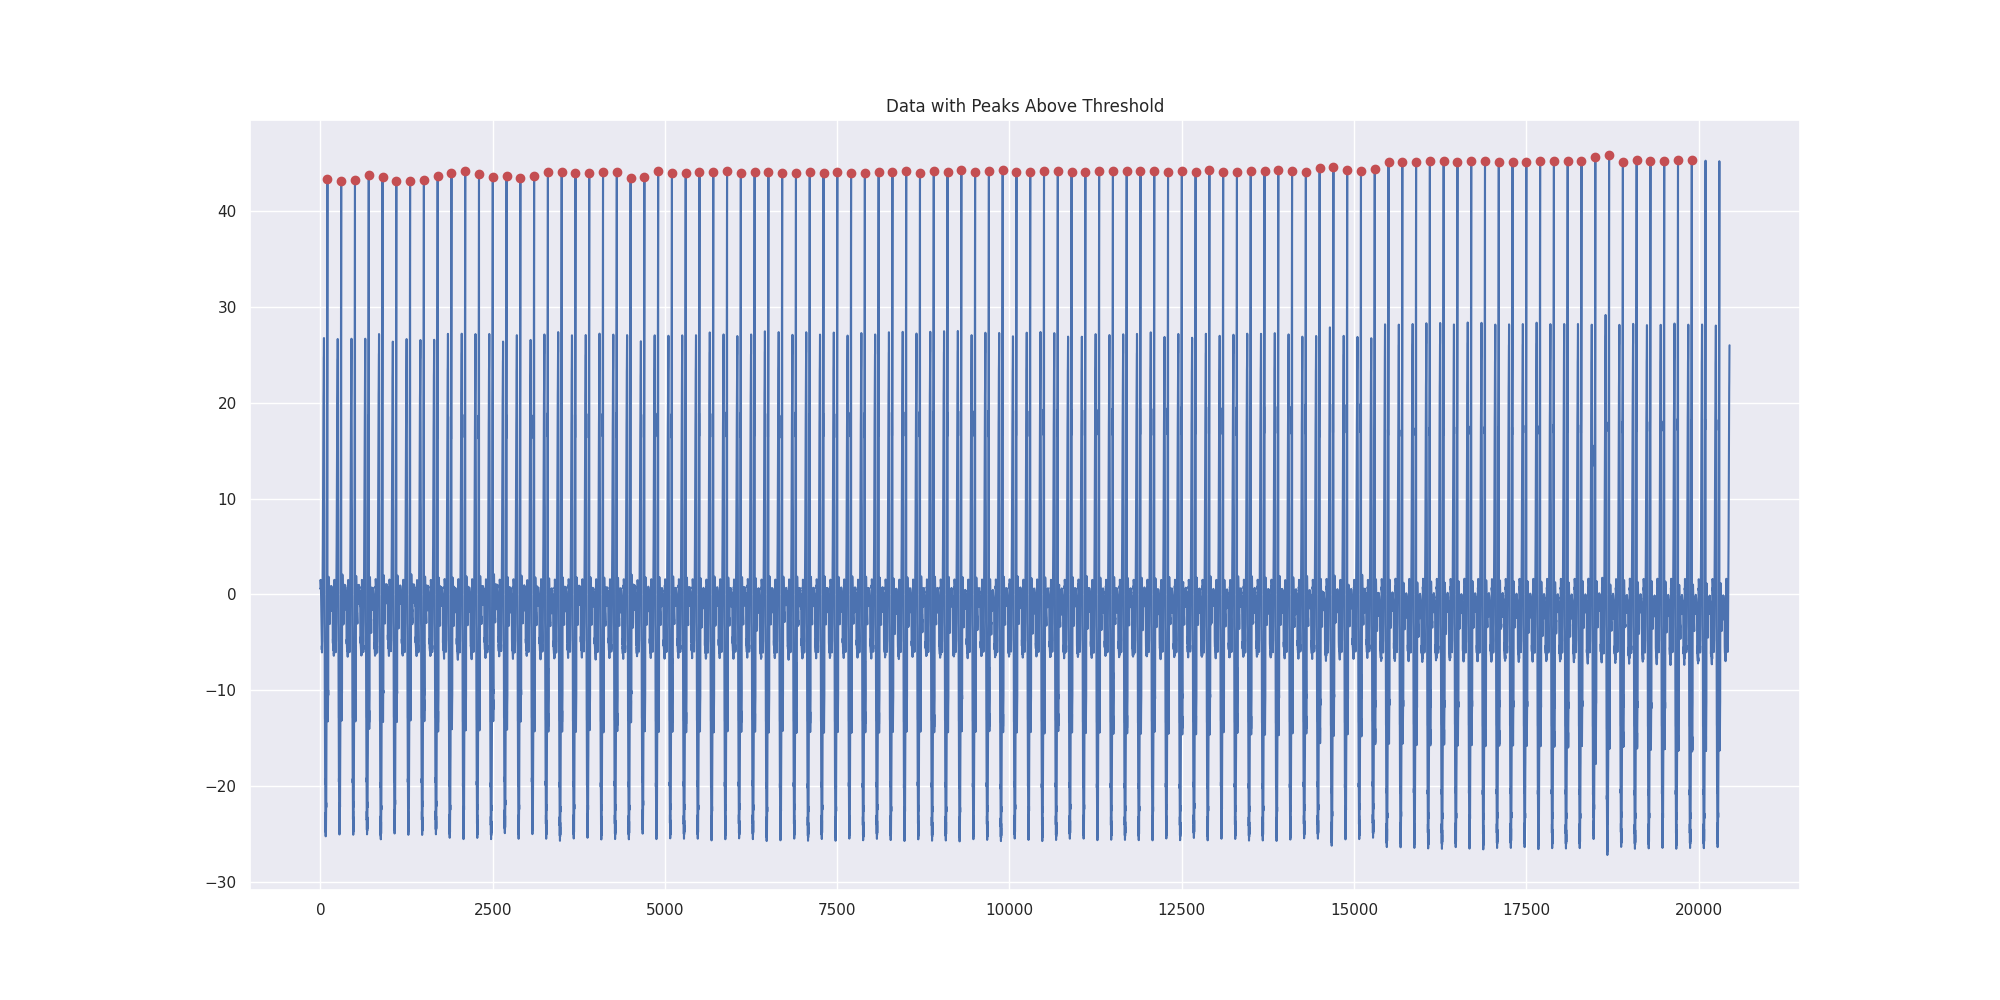

In [4]:
analyze_range('p01',40,140)